# Aufgabe-F-FilmDialoge

## Allgemeines

Eine allgemeine Beschreibung der Laboraufgaben inklusive des Vorgehens, den Bewertungsrichtlinien und der Abgabe finden Sie  <a href="ML-allgemein.ipynb">hier</a>

## Datenquelle


* Laden Sie ihre Daten von http://141.72.190.207/ml_lab/F_dialoge herunter
    * Die Daten sind geschützt. 
        * Sie müssen evtl. in einem Netzwerk der DHBW (z.B. WLAN, VPN, ...) angemeldet sein. 
        * Sie können sich auf der Webseite mit dem Benutzernamen dhbw und dem Zugangsnamen "ml_LaB_4$" anmelden. 
* Die Daten sind in einem anwendungsspezifischen Format gespeichert.
    * Sie finden evtl. Informationen über die Daten in einer "README" Datei. 
    * Finden Sie keine solche Datei sind die Daten selbst erklärend. 
    
    



## Aufgabe

Die Daten-Sammlung 
* besteht aus Dialogen aus verschiedensten Filmen
* ist in der Readme Datei beschrieben

Erstellen Sie aus den einen Chatbot, der auf eine Frage mit einer Antwort im "Filmjargon" antwortet! 
* Verwenden Sie tiefe Neuronale Netze zu Erstellen des Chatbots! 
* Passen Sie den Chatbot so an, dass er für unterschiedliche Film-Genres unterschiedlich antwortet! 


# Lösung

Die Lösung der Aufgabe besteht aus mehreren Teilschritten, welche im Folgenden kurz genannt werden:

* Daten einlesen
* Daten vorverarbeiten
* Model erstellen
* Model trainieren
* Model abspeichern
* Model ausführen


# Abhängigkeiten des Projekts

* Tensorflow 2.8.2

In [131]:
import tensorflow as tf
import random 
import re #re = regular expressions
import os
import numpy as np 
from collections import Counter
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from matplotlib import pyplot as plt

# Eigene Abhängigkeiten des Projekts

* 

In [132]:
import src.data_helper as dh

## Konstanten

In [133]:
max_train_size = 25000
max_test_size = 10000

# Daten einlesen

Hier werden zuerst die rohen Daten eingelesen und innerhalb der Hilfsfunktion "readDataToLines" mit des "newline" Zeichen getrennt. Die Daten werden zwei Listen gespeichert, welche dann zurückgegeben werden.
Verwendet wurden folgende Funktionen:

* "open" um die Datei zu öffnen
* "read" um die Datei zu lesen
* "split" um die Daten anhand des "newline" Zeichen zu trennen und in einer Liste zu speichern

In [134]:
# read the data from the files
movie_lines, movie_conversations = dh.readDataToLines("data/unzipped/movie_lines.txt", "data/unzipped/movie_conversations.txt")

# Daten vorverarbeiten

In [135]:
# extract and mix conversations to a list
conversations_list = dh.readConversationsToList(movie_conversations)
random.shuffle(conversations_list)

# create a dictionary that maps each line id to the corresponding line
id2line = dh.readLinesToDict(movie_lines)

# remove all unnecessary characters from the lines and replace short forms with the full words
id2line = dh.cleanLines(id2line)

# split the conversations into requests and responses, each answer is used as a request for the next answer
requests, responses = dh.splitConversationsToRequestAndResponse(conversations_list, id2line)

# delete temporary variables
del(movie_lines, movie_conversations, conversations_list, id2line)

### Parameter wählen

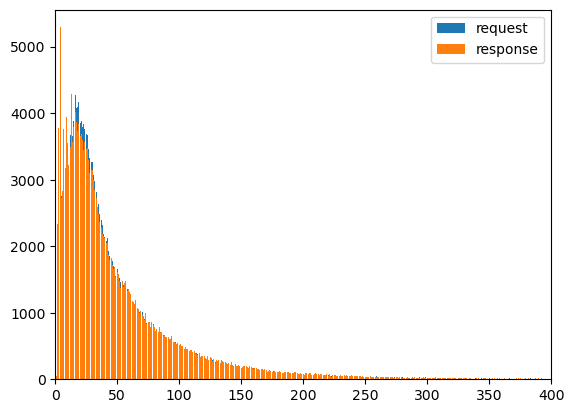

In [136]:
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

# get the length of each line of the requests and save the occurrences in a dictionary
lengths_request = {}
for sentence in requests:
    length = len(sentence)
    if length in lengths_request:
        lengths_request[length] += 1
    else:
        lengths_request[length] = 1

# get the length of each line of the responses and save the occurrences in a dictionary
lengths_response = {}
for sentence in responses:
    length = len(sentence)
    if length in lengths_response:
        lengths_response[length] += 1
    else:
        lengths_response[length] = 1

# plot the occurrences of the lengths of the requests and responses in the same plot while only showind x values up to 200
plt.bar(lengths_request.keys(), lengths_request.values(), label="request")
plt.bar(lengths_response.keys(), lengths_response.values(), label="response")
plt.xlim(0, 400)
plt.legend()
plt.show()


# based on the result set the parameters
max_wordcount_in_sentence = 50


In [137]:
#delete all quotes with a length !e [2;max_wordcount_in_sentence]
for i, request in enumerate(requests):
    if len(request.split()) > max_wordcount_in_sentence or len(request.split()) < 2:
        del(requests[i])
        del(responses[i])

for i, response in enumerate(responses):
    if len(response.split()) > max_wordcount_in_sentence or len(response.split()) < 2:
        del(requests[i])
        del(responses[i])

print(f"Länge Frage: {len(requests)}")
print(f"Länge Antworten: {len(responses)}")

Länge Frage: 186072
Länge Antworten: 186072


In [138]:
# limit the size of the dataset

test_requests = requests[max_train_size: (max_train_size+max_test_size)]
test_responses = responses[max_train_size: (max_train_size+max_test_size)]
requests = requests[:max_train_size]
responses = responses[:max_train_size]

# encapsule the requests and responses with the tokens <S> (Start) and <E> (End)
responses = dh.encapsuleWithTokens(responses, "<S>", "<E>")


# get a dictionary of all unique words with their frequency
word2count = dh.getWord2Count(requests, responses)

# filter out words with a frequency of 5 or less
min_wordFrequency = 5
word2count = {k:v for k,v in word2count.items() if v > min_wordFrequency}

Wie man in der obigen Grafik erkennt, sind ab einer Sequenzlänge von 200 nur noch wenige Daten vorhanden. Da die Sequenzlänge maßgeblich auch für den Speicherbedarf in weiteren Schritten ist, wird diese hier auf 200 begrenzt.

In [139]:
oov_token = '<UNK>'
maxlen = len(word2count) + 1
del(word2count)


tokenizer = Tokenizer(num_words=maxlen, oov_token=oov_token)
tokenizer.fit_on_texts(requests)
tokenizer.fit_on_texts(responses)

word2index = tokenizer.word_index
index2word ={k:v for v,k in word2index.items()}
print('Größe des Wörterbuchs: ',len(word2index))

np.save(arr=word2index, file="data/word2index.dict")
np.save(arr=index2word, file="data/index2word.dict")

Größe des Wörterbuchs:  21041


In [140]:
inputEncoder = tokenizer.texts_to_sequences(requests)
inputDecoder = tokenizer.texts_to_sequences(responses)
test_inputEncoder = tokenizer.texts_to_sequences(test_requests)
test_inputDecoder = tokenizer.texts_to_sequences(test_responses)


# remove start token from decoder input so that the decoder doesn't learn to just copy the start token to each output, don't remove the end token because the decoder should learn when to stop with generating output
outputDecoder = dh.removeStartToken(inputDecoder)
test_outputDecoder = dh.removeStartToken(test_inputDecoder)

[[69, 2017, 12], [46, 19, 27, 22], [5, 53, 22, 27, 38, 10, 240, 930, 1510, 7, 18, 149], [4, 18, 33, 57, 7, 13, 24, 7, 64, 135, 1, 65, 13, 9, 4, 53, 11, 111, 11, 8, 122, 104, 43, 4, 141, 10, 219, 16, 392], [5, 70, 4, 5, 23, 9, 753, 17, 29, 1231], [33, 93, 120, 4, 26, 179, 352, 3663, 66, 1229, 22, 8, 315, 42, 4, 437, 346, 11, 151, 168, 4, 45, 22, 145, 1666, 48, 11, 26, 213, 50], [35, 4, 28, 12, 27, 38, 10, 705, 95, 9, 105, 916], [5, 23, 9, 1, 50, 47], [65, 9]]


In [141]:
max_sentence_length = dh.get_maximum_sentence_length(inputEncoder, inputDecoder, test_inputEncoder, test_inputDecoder)
pad_type = 'post'
trunc_type = 'post'

# use the keras function pad_sequences to pad the data with zeros (which represent a filling token) to the maximum length
inputEncoder = pad_sequences(inputEncoder, padding=pad_type, truncating=trunc_type, maxlen=max_sentence_length)
inputDecoder = pad_sequences(inputDecoder, padding=pad_type, truncating=trunc_type, maxlen=max_sentence_length)
outputDecoder = pad_sequences(outputDecoder, padding=pad_type, truncating=trunc_type, maxlen=max_sentence_length)
test_inputEncoder = pad_sequences(test_inputEncoder, padding=pad_type, truncating=trunc_type, maxlen=max_sentence_length)
test_inputDecoder = pad_sequences(test_inputDecoder, padding=pad_type, truncating=trunc_type, maxlen=max_sentence_length)
test_outputDecoder = pad_sequences(test_outputDecoder, padding=pad_type, truncating=trunc_type, maxlen=max_sentence_length)

# convert the decoder input to a one-hot encoded vector which the model can use
outputDecoder = tf.keras.utils.to_categorical(outputDecoder, num_classes=len(word2index), dtype="float32") # using float32 even though it's memory intensive because later steps need it to be float32
test_outputDecoder = tf.keras.utils.to_categorical(test_outputDecoder, num_classes=len(word2index), dtype="float32")

# Model erstellen

Das Erzeugen der einzelnen Layer ist in der Reihenfolge implementiert, nach welcher Daten das Model durchlaufen.


In [ ]:
#hyperparameters
outputDimension = 50 
lstm_units = 256

#encoder input, embedding and lstm

# input tensor for the encoder, shape of each vector is determined by max_length which was also used to pad the data
inputEncoderTensor = tf.keras.Input(shape=(max_length, ), name = "inputEncoderTensor")

# embedding layer of the encoder, the input is the input tensor, the output is the embedding tensor
encoderEmbedding = tf.keras.layers.Embedding(len(word2index) + 1, output_dim = outputDimension, input_length = max_length, trainable = True, name = "embeddingEncoderLayer")(inputEncoderTensor)

# LSTM layer of the encoder, the input is the embedding tensor, the output is the output tensor and the hidden state of the encoder
encoderLSTM, encoderHiddenState, encoderCellState = tf.keras.layers.LSTM(units = lstm_units, return_sequences = True, return_state = True, name = "lstmEncoderLayer")(encoderEmbedding)



#decoder input, embedding, lstm and dense

# input tensor for the decoder, shape of each vector is determined by max_length which was also used to pad the data
inputDecoderTensor = tf.keras.Input(shape=(max_length, ), name="inputDecoderTensor")

# embedding layer of the decoder, the input is the input tensor, the output is the embedding tensor
decoderEmbedding = tf.keras.layers.Embedding(len(word2index) + 1, output_dim = outputDimension, input_length = max_length, trainable = True, name = "embeddingDecoderLayer")(inputDecoderTensor)

# LSTM layer of the decoder, the input is the embedding tensor and the state of the previous lstm layer, the output is the output tensor and the hidden state of the decoder
decoderLSTM, decoderHiddenState, decoderCellState = tf.keras.layers.LSTM(units = lstm_units, return_sequences = True, return_state = True, name = "lstmDecoderLayer")(decoderEmbedding, initial_state = [encoderHiddenState, encoderCellState])

# dense layer of the decoder, the input is the output tensor of the lstm layer, the output is the output tensor of the dense layer
# the dense layer has the same number of units as the number of words in the dictionary because the output of the dense layer is a vector with a probability for each word in the dictionary
decoderDense = tf.keras.layers.Dense(units = len(word2index), activation = "softmax", name = "denseLayer")(decoderLSTM)

# Define the model 
model = tf.keras.models.Model([inputEncoderTensor, inputDecoderTensor], decoderDense)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy')

# generate an early stopping callback to stop training when the validation loss stops improving so that the model doesn't overfit
# waits 3 epochs before stopping
# use val_loss as the metric because categorical_crossentropy calculates the difference between the predicted and actual values and by monitoring wether or not the loss would be decreasing or increasing we can see if the model is improving or not
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

# Train the model on the training data and evaluate it on the validation data
model.fit(x=[inputEncoder, inputDecoder],y=outputDecoder , epochs=10, batch_size=32, callbacks=[earlyStopping])

# Evaluate the model on the validation set and store the results
loss, accuracy = model.evaluate([test_inputEncoder, test_inputDecoder], test_outputDecoder)
print('Test loss:', loss)
print('Test accuracy:', accuracy)


# Model trainieren

# Model abspeichern

In [ ]:
for layer in model.layers:
    weights = layer.get_weights()
    if weights != []:
        numpy.savez(f'models/{layer.name}.npz', weights, dtype=object)

# Model ausführen